In [1]:
from torchvision import models, transforms
from torchsummary import summary
import torch
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.dirname(current_dir))

from lib.src import *
from lib.utils import *

from pytorch_grad_cam import GradCAM, HiResCAM, AblationCAM, ScoreCAM, GradCAMPlusPlus, XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

2024-12-12 21:03:30.634190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 21:03:30.645781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734033810.663406  112013 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734033810.667546  112013 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 21:03:30.683828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


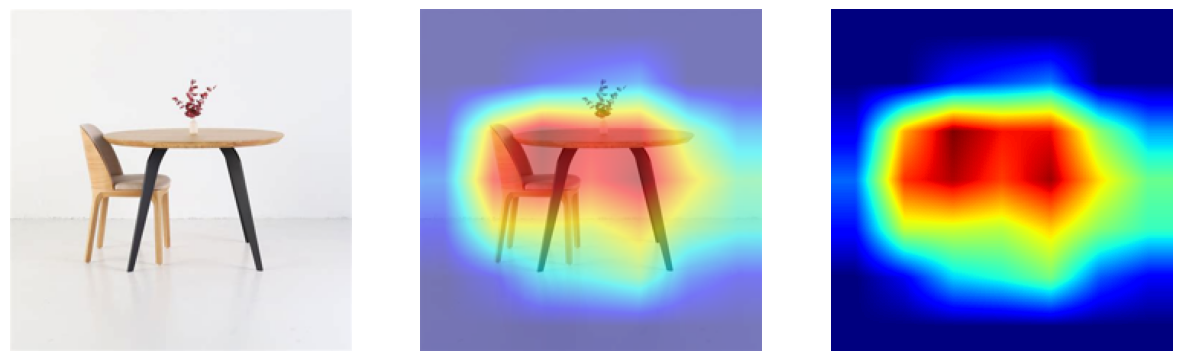

folding chair
57.136512756347656
559


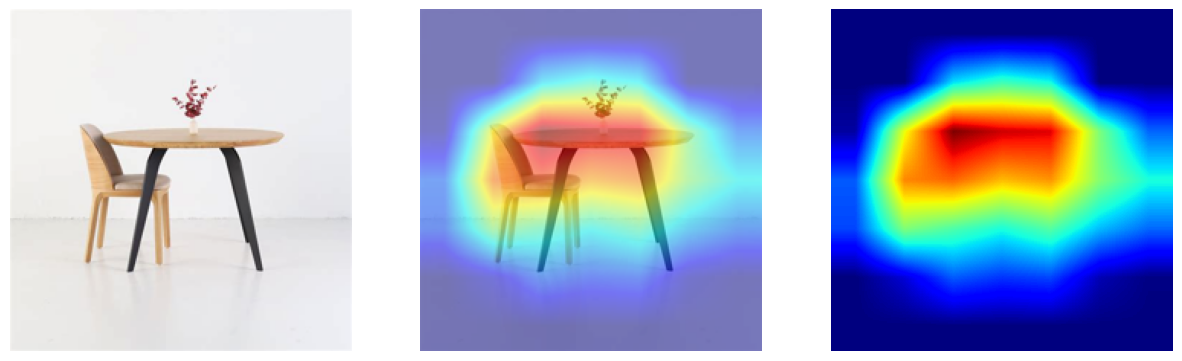

dining table
37.047489166259766
532


In [2]:
path = 'images/stół_krzeselko.jpg'

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1].conv3]
class_names = np.loadtxt('imagenet_classes.txt', str, delimiter='\t')

img = get_image_torch(path, 224, 224)
model.eval()
out = model(img.unsqueeze(0))

# list top-5 classes predicted by model
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
[(class_names[idx], percentage[idx].item(), idx) for idx in indices[0][:5]]


for indice in indices[:, :2][0]:
    idx = indice.item()
    input_tensor = get_image_torch(path, 224, 224).unsqueeze(0)
    targets = [ClassifierOutputTarget(idx)]

    with GradCAM(model=model, target_layers=target_layers) as cam:
      gradcam = cam(input_tensor=input_tensor, targets=targets).squeeze(0)
    overlay_plot_torch(input_tensor.squeeze(), gradcam, 0.5)
    print(class_names[idx])
    #print softmax value
    print(percentage[idx].item())
    print(idx)

In [3]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import imageio
import numpy as np

input_tensor = get_image_torch('images/stół_krzeselko.jpg', 224, 224).unsqueeze(0)
targets = [ClassifierOutputTarget(532)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    cam = cam(input_tensor=input_tensor, targets=targets).squeeze(0)

gif_images = []

for threshold in np.arange(0.00, 1.0, 0.01):
    cut_img = delete_the_least_important_pixels(input_tensor.squeeze(), cam, threshold)
    
    cut_img_np = cut_img.permute(1, 2, 0).detach().cpu().numpy()
    
    gif_images.append((cut_img_np * 255).astype(np.uint8))

imageio.mimsave('chair_gradcam.gif', gif_images, duration=0.1)

In [4]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import imageio
import numpy as np

input_tensor = get_image_torch('images/stół_krzeselko.jpg', 224, 224).unsqueeze(0)
targets = [ClassifierOutputTarget(559)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    cam_husky_lib = cam(input_tensor=input_tensor, targets=targets).squeeze(0)

gif_images = []

for threshold in np.arange(0.00, 1.0, 0.01):
    cut_img = delete_the_least_important_pixels(input_tensor.squeeze(), cam_husky_lib, threshold)
    
    cut_img_np = cut_img.permute(1, 2, 0).detach().cpu().numpy()
    
    gif_images.append((cut_img_np * 255).astype(np.uint8))

imageio.mimsave('table_gradcam.gif', gif_images, duration=0.1)

In [5]:
path = 'images/husky.jpg'

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1].conv3]
class_names = np.loadtxt('imagenet_classes.txt', str, delimiter='\t')

img = get_image_torch(path, 224, 224)
model.eval()
out = model(img.unsqueeze(0))

# print softmax

out = torch.nn.functional.softmax(out, dim=1)

out[0, 250]

tensor(0.4359, grad_fn=<SelectBackward0>)

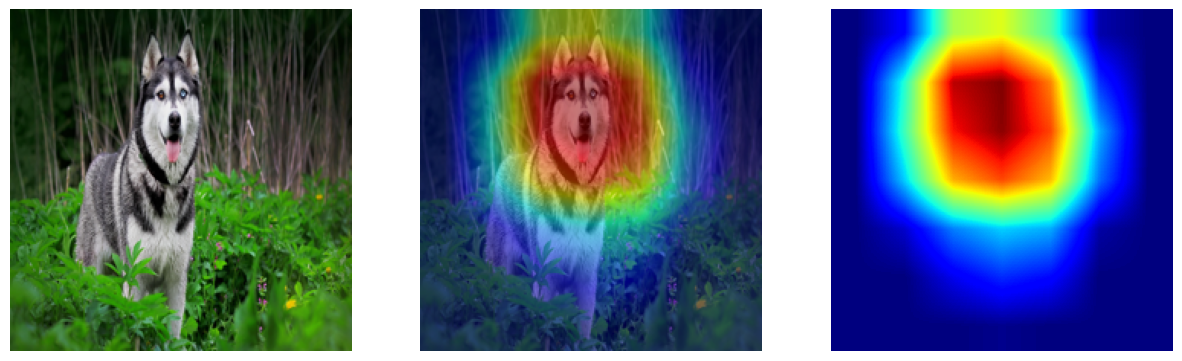

In [6]:
gradcam = get_gradcam(img, model, model.layer4[-1].conv3)
overlay_plot_torch(img, gradcam, 0.5)

In [7]:
img_d = delete_the_least_important_pixels(img, gradcam, 0.01)

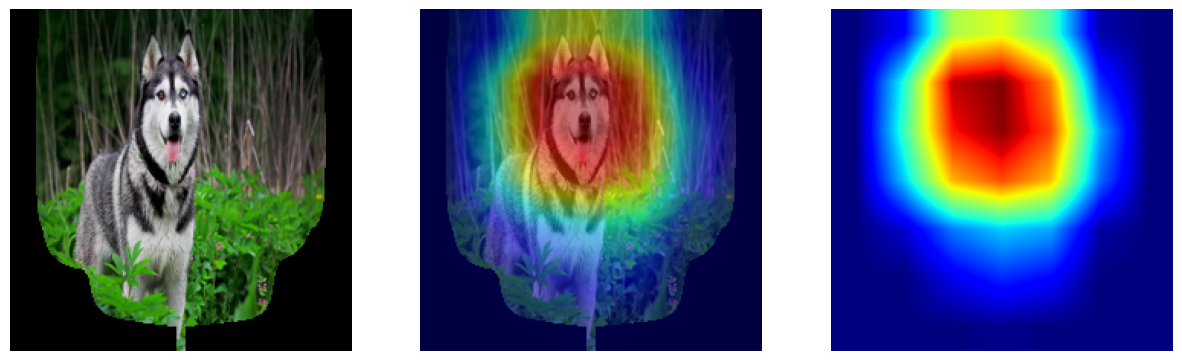

In [8]:
overlay_plot_torch(img_d, gradcam, 0.5)

In [9]:
model.eval()
out = model(img_d.unsqueeze(0))

out = torch.nn.functional.softmax(out, dim=1)

out[0, 250]

tensor(0.1400, grad_fn=<SelectBackward0>)

In [10]:
"""with open('imagenet_classes.txt', 'r') as f:
    content = f.read()
    content = content.lower()
    content = content.replace(' ', '_')
    content = content.replace('-','_')
    content = content.replace('\'', '_')

    with open('temp1.txt', 'w') as ff:
        ff.write(content)
with open('imagenet.txt', 'r') as f:
    content = f.read()
    list_of_lines = list()
    for line in content.split('\n'):
        if line == '':
            continue
        left, mid, right = line.split()
        right = right.lower()
        right = right.replace('-', '_')
        right = right.replace('\'', '_')
        list_of_lines.append(left + ' ' + mid + ' ' + right)
    
    with open('temp2.txt', 'w') as ff:
        ff.write('\n'.join(list_of_lines))
"""

"with open('imagenet_classes.txt', 'r') as f:\n    content = f.read()\n    content = content.lower()\n    content = content.replace(' ', '_')\n    content = content.replace('-','_')\n    content = content.replace(''', '_')\n\n    with open('temp1.txt', 'w') as ff:\n        ff.write(content)\nwith open('imagenet.txt', 'r') as f:\n    content = f.read()\n    list_of_lines = list()\n    for line in content.split('\n'):\n        if line == '':\n            continue\n        left, mid, right = line.split()\n        right = right.lower()\n        right = right.replace('-', '_')\n        right = right.replace(''', '_')\n        list_of_lines.append(left + ' ' + mid + ' ' + right)\n    \n    with open('temp2.txt', 'w') as ff:\n        ff.write('\n'.join(list_of_lines))\n"

In [11]:
id_name = dict()
dups_id_name = dict()

for i, name in enumerate(open('imagenet_classes.txt', 'r')):
    name = name[:-1]
    name = name.lower()
    name = name.replace(' ', '_')
    id_name[i] = name

len(id_name)

1000

In [12]:
hash_name = dict()
dups_hash_name = dict()

for line in open('imagenet.txt', 'r'):
    line = line[:-1]
    h, i, n = line.split()
    n = n.lower()
    hash_name[h] = n
len(hash_name)

1000

In [13]:
DICT = dict()

for k1, v1 in id_name.items():
    for k2, v2 in hash_name.items():
        if v1 == v2:
            DICT[k1] = (k1, k2, v1)
            DICT[k2] = (k1, k2, v1)
len(DICT)

2000

In [14]:
# iterate over some classes
# iterate over some pic
# count softmax
# apply deletion
# count softmax on deletion

In [25]:
import random
import os
from tqdm import tqdm


model = resnet50(pretrained=True)
target_layers = [model.layer4[-1].conv3]
targets = []

first = []
second = []

i = 0
for dir_name in tqdm(random.sample(os.listdir('imagenet-mini/train'), 5)):
    #print(i)
    #i += 1
    #print(dir_name)
    for file_name in random.sample(os.listdir(f'imagenet-mini/train/{dir_name}'), 5):
        orginal_img = get_image_torch(f'imagenet-mini/train/{dir_name}/{file_name}', 224, 224)
        id, hash, name = DICT[dir_name]

        model.eval()
        #print(orginal_img.shape)
        out = model(orginal_img.unsqueeze(0))
        out = torch.nn.functional.softmax(out, dim=1)

        #print('before', name, out[0, id].item())

        first.append(out[0, id].item())

        #print('true', name, out[0, id].item())

        # argmax 

        model.eval()
        out = model(orginal_img.unsqueeze(0))
        out = torch.nn.functional.softmax(out, dim=1)
        argmax = torch.argmax(out, dim=1)
        #print('predicted', DICT[argmax.item()][2], out[0, argmax].item())
        #print(dir_name, file_name)

        with GradCAM(model=model, target_layers=target_layers) as cam:
            gradcam = cam(orginal_img.unsqueeze(0), targets=[ClassifierOutputTarget(id)]).squeeze(0)

        #overlay_plot_torch(orginal_img, gradcam, 0.5)

        del_image = delete_the_least_important_pixels(orginal_img, gradcam, 0.01)

        with GradCAM(model=model, target_layers=target_layers) as cam:
            gradcam = cam(del_image.unsqueeze(0), targets=[ClassifierOutputTarget(id)]).squeeze(0)

        #overlay_plot_torch(del_image, gradcam, 0.5)

        model.eval()
        out = model(del_image.unsqueeze(0))
        out = torch.nn.functional.softmax(out, dim=1)
        #print('del', name, out[0, id].item())

        #print('after', name, out[0, id].item())
        second.append(out[0, id].item())



        #plt.imshow(orginal_img.permute(1, 2, 0))
        #plt.axis('off')
        #plt.show()



100%|██████████| 5/5 [00:20<00:00,  4.12s/it]


In [28]:
first_arr = np.array(first)
second_arr = np.array(second)
np.maximum(0, first_arr - second_arr).sum() / first_arr.shape[0], (first_arr < second_arr).sum() / first_arr.shape[0]

(0.08080905392765998, 0.32)